# <center> Neural Network Project - Binary Classification with Keras</center>
## <center>A Model learning and predicting chances of survival for the passengers onboard the 'Titanic' Vessel</center>
## <center>by Karine Legrand</center>
### <center>January 2022</center>

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#data">Data Acquisition and Wrangling</a>
<li><a href="#preprocessing">Preprocessing for Keras</a>
<li><a href="#build">Building and training the Model</a></li>
<li><a href="#predict">Predicting 'new' labels</a></li>
<li><a href="#results">Interpreting the Results</a></li>    
<li><a href="#conclusion">Conclusion and Limitations</a></li>
</ul>

<a id='intro'></a>
## Introduction

Let's consider the well-known dataset describing characteristics of the Passengers onboard the infamous 'Titanic' Vessel (April 14th of 1912). We could, as I did in another Project, conduct an Exploratory Data Analysis to get Insights about which factors would affect the chance of survival. In other words we could analyse with statistical methods and visualizations, wether -and under which possible circonstances-, some people were more likely to survive the tragedy than others.<br>Another Approach, that we will take here, is to design a Neural Network working as a 'Classifier'.<br> The aim is to take a set of features in the dataset, that will be used to train a model, which in turn, would be able to predict the outcome of our dependent variable, i.e  wether a passenger survived or not. We want to predict the outcome of a Category with just two levels (True/False, Survived/Trepassed, 1/0), hence, we are dealing with a so-called "Binary Classification Problem".<br>We choose to use the 'Keras' framework, built on TensorFlow to implement an simple Hands-On Solution to our Problem.

<a id='data'></a>
## Data Acquisition and Wrangling

In this section we will load and wrangle the dataset to fix any possible issues with the data.<br>
This does not essentially differ from what we would do for an Exploratory Data Analysis, so I can use and reproduce steps I did in my previous Project here.<br><br>
<b><i>Note</i>:</b> Data treatments that are more specific to the use of Keras, as for instance, integers-formatting for categorical values, will be handled together with proper neural network Data formatting, in the next <a href="#preprocessing">Preprocessing</a> section

#### Importing the 'Data Science Stack Libraries' 

In [1]:
# first the 'usual suspects' of the Data Analysis Stack
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# the libs for Machine Learning Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# the libs for Neural Network modelling
import tensorflow as tf
from tensorflow import keras
from keras import layers, Sequential

In [2]:
tf.__version__

'2.6.0'

#### Load the csv File with pandas

The Dataset, can be found [there](https://www.kaggle.com/c/titanic/data). It contains a subset list of the Passengers that were on board with characteristic informations for each of them and wether they survived or not.

In [3]:
# Load the csv file
df_titanic = pd.read_csv('train.csv')
print(df_titanic.shape)

(891, 12)


Their are 891 rows in the Dataframe, each containing 12 columns or variables.

### First Glance at the Data using head, info and describe and first decisions about the variables of interest:

In [4]:
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Are there any duplicates in the Dataframe?

In [5]:
df_titanic.duplicated().sum()

0

There are no duplicates. Each row is a distinct valid observation (characteristics for one person on board of the ship).

I decided to drop some columns, for clarity purposes, for the corresponding independant variables "PassengerId, Name and Ticket", which I suspect not to correlate with our outcome variable.


In [6]:
df_titanic.drop(columns=['PassengerId', 'Name', 'Ticket'], inplace=True)
df_titanic.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S


Overview of the Columns-meaning:
- "SibSp" stands for "Siblings/Spouse",
- "ParCh" stands for "Parents/Children",
Both variables indicates if a Passenger had Sibling(s)/Partner and Parents/Children on board or none of them and travelling alone,
- "Embarked" is related to the Port on the Route where People embarked, either "S for Southampton", "C for Cherbourg" or "Q for Queenstown" in the Uk and in France,
- "Fare" is the price the person paid for him/herself and their family if any,
- "Cabin" is the Reference number of the reserved cabin if any,
- "Pclass" is the Travel-class of the Passenger (First, Second or Third).
The other columns are self explanatory.

What is the type of the variables, are there missing values?

In [7]:
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Cabin     204 non-null    object 
 8   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 62.8+ KB


The Data Types seem to be matching the types for all columns.<br>
There are missing values for the columns \['Age', 'Cabin', 'Embarked'\]. Before inspecting them closer and decide how tho handle them, let us gain some statistics summary for the numerical variables with 'describe' and have an overview of the distributions.

In [8]:
df_titanic.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


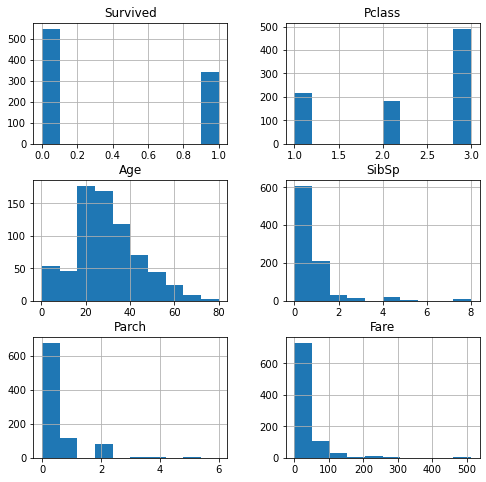

In [9]:
df_titanic.hist(figsize= (8,8));

In [10]:
print(df_titanic.Survived.mean()*100)

38.38383838383838


**First Assessments and Overview of the numerical variables:**<br><br>
**Distribution of the 'Age' variable:**<br>
Most of the People were approximately between 20 and 40 years old. There were also some very young children (not even one year old)and a few elderly People on board (One was 80 year old). In average, People were about 30 year old.<br>
**Distribution of the 'Pclass' variable:**<br>
About 200 People travelled each in First and Second Class and most of them, more than the double, travelled in the cheapest Third-class.<br>
**Distribution of 'SibSp' and 'ParCh' variables:**<br>
A vast majority of the People travelled alone.<br>
**Distribution of 'Fare' variable:**<br>
A vast majority of People, $75\%$, paid less than 31\$ for the trip (which matches the fact that most people travelled in Third-class)<br>
**Distribution for the 'Survived' variable:**<br>
Most people, $61.6\%$ of them, did not survive (which is a slightly smaller proportion as the real Proportion of People who died in the Tragedy, since we are working on a Dataset with less than half of the total Passengers that were on board (2200)) 

<i><b>An important note for the next Section:</b></i> The levels of the class we want to predict are not equally distributed in the dataset, i.e there are less People who survived than died. It will be useful to reflect the same proportions in the different subsets of data we will produce from the dataset for our model (training, validation and testing data subsets)

#### Decision for handling the Quality Issue concerning missing values for the 'Age' column:

Let us inspect the rows for which the 'Age' value is missing. We want to make sure these records do not have a certain characteristic in common for example, which would make them being a distinct group of People. 

In [11]:
df_age_missing = df_titanic[df_titanic.Age.isnull()]
print(df_age_missing.shape)

(177, 9)


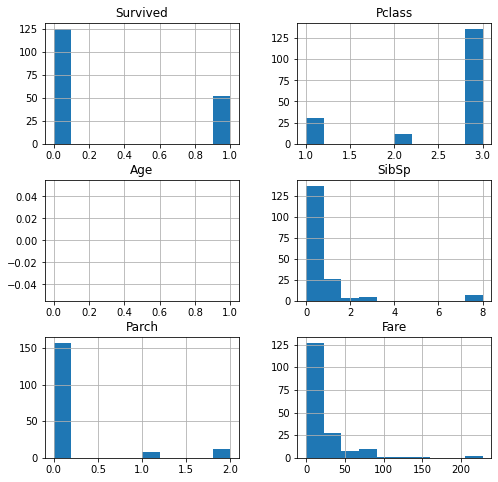

In [12]:
df_age_missing.hist(figsize=(8,8));

The characteristics for these rows do not show any particular difference from the whole dataset, we decide to handle these missing values by replacing them with the average age.<br>
**We will handle this quality issue in the next "Data Cleaning" section.** 

#### Decision for handling the Quality Issue concerning missing values for the 'Embarked' column:

In [13]:
print(df_titanic[df_titanic.Embarked.isnull()].shape)

(2, 9)


Since there are only 2 rows missing this information we can decide to just drop them.<br>We will do this, as well, in the next **"Data Cleaning"** section.

**Decision for handling missing values in the 'Cabin' column:**
We suspect there is a value in the column only for the passengers that did have a cabin. So mainly for First class plus the members of the crew. We could either replace the missing values with "None" or just ignore the missing values. Let us have a look to confirm if our Intuition was right:

In [14]:
df_cabin = df_titanic.loc[df_titanic.Cabin.notna()]
df_cabin.Pclass.value_counts()

1    176
2     16
3     12
Name: Pclass, dtype: int64

We decide to replace missing values with 'None .

### Data Cleaning: Handling the quality issues detected previously

#### Quality Issue 1: 
#### Define: 
We want to replace missing values in the 'Age' column by its mean value.

#### Code:

In [15]:
df_titanic.Age.fillna(df_titanic.Age.mean(), inplace=True)

#### Test:

In [16]:
print(df_titanic.Age.isna().sum())

0


#### Quality Issue 2:

#### Define:
We drop the 2 rows with missing values in the 'Embarked' column:

#### Code:

In [17]:
df_titanic.dropna(subset=['Embarked'], inplace=True)

#### Test:

In [18]:
print(df_titanic.shape)

(889, 9)


#### Quality Issue 3:

#### Define:
We replace the missing values in the 'Cabin' column with 'None:

#### Code:

In [19]:
df_titanic.Cabin.fillna('None', inplace=True)

#### Test:

In [20]:
print(df_titanic.Cabin.isna().sum())

0


In [21]:
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Sex       889 non-null    object 
 3   Age       889 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Fare      889 non-null    float64
 7   Cabin     889 non-null    object 
 8   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 69.5+ KB


### Insights from assessing the Dataset and Decisions for structuring our Model:

#### What is the structure of the dataset?
The Dataset contains 889 observations of persons embarked on the Titanic Vessel. There are 9 columns we decided to keep describing characteristics of each Person.


#### What is/are the main feature(s) of interest in the dataset?
The <b>Response</b> Variable, which we will set as our prediction <b>Label</b> in our Model is the column `'Survived'`. The other 8 columns will be the <b>Inputs</b> or <b>Features</b> in our Neural Network Model:
`['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']`


<a id='preprocessing'></a>
## Preprocessing for Keras

In this section we will further process our Data so that it becomes "Model-ready" to work with. Different steps need to be taken:
- 1) One hot encode categorical variables
- 2) Setting Features and Labels
- 3) Split our Features and associated Labels Data into 3 Chunks: Training, Validation and Test
- 4) Normalize the Input Data so that the different ranges across the Features's values do not tend to bias the weights of the neurons across the network

<br>

### <u>1) One-hot-encode categorical variables</u>

The categorical non-ordinal features need to be converted in a binary form, because our model can only work with numerical values. This is the case for `['Sex', 'Cabin', 'Embarked']`.
<i>Note:</i> The feature `Pclass` is categorical and integer-encoded (1 to 3). It is also <i>ordinal</i>. It means that the travelling Class has a rank (1 is the best, 3 is the worst Class). In this case it is important to preserve this valuable information and keep the levels together in one single variable, as the model can interpret this.


In [22]:
# One-hot-encode 'Sex' and Embarked columns
df_titanic = pd.get_dummies(df_titanic, columns= ['Sex', 'Embarked'])


In [23]:
df_titanic.head(2)

,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,None,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,C85,1,0,1,0,0


The 'Cabin' column, needs to be casted directly in binary Form: The value is either a reference to an existing cabin, or it is 'None'. Let's encode this as a boolean Variable.

In [24]:
df_titanic['Cabin'] = np.where(df_titanic.Cabin=='None', 0, 1) 

In [25]:
df_titanic.head(2)

,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,1,0,1,0,0


Wrangling the Data is now done! We can move on to format and preprocess our Model Data.

In [26]:
# Saving the wrangled Dataset for reuse purposes:
df_titanic.to_csv('titanic_DL_ready.csv', index=False)

### <u>2) Setting Features and Labels</u>

In [27]:
# Set Features and labels:

X = df_titanic.drop(columns=['Survived']) # all the columns except the Response variable can be fed in our model.
y = df_titanic['Survived']

print(X.shape, type(X))
print(y.shape, type(y))

(889, 11) <class 'pandas.core.frame.DataFrame'>
(889,) <class 'pandas.core.series.Series'>


'X' is a 2D Tensor which is our Input vector and 'y' is the 1D Tensor as the label that we want to predict ('Survived' or 'did not Survive').

### 3) Split our Features and associated Labels Data into 3 Chunks: Training, Validation and Test

An mandatory Preprocessing phase is to split our Data into these 3 blocks:<br>
The <b>Training set</b> (Features and Labels) will be used to train the Neural Network and let it find the optimal weights to predict the Labels.<br>
The <b>Validation Set</b> is used for unbiased Model evaluation during the training phase.
Finally the <b>Test Set</b> is used for evaluating the Model's performance once it has trained.

We will set the following proportions for the three different chunks: about 64% for training, 20% for testing and 16% for validating. We will also want to keep the same proportion of the label values across the randomly splitted data, because these are imbalanced (about 60% of People survived against 40% of People who did not) and will therefore need to <i>stratify</i> the data against our Label values, when splitting them.

In [28]:
# Extract the Training and Test sets with scikit-learn 'train_test_split'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Extract the Validation set by applying 'train_test_split' again
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)


print("Shapes:\nX_train:", X_train.shape, "\nX_test: ", X_test.shape, "\nX_valid: ", X_valid.shape)
print("Labels shapes (train, test, validate): ", y_train.shape, y_test.shape, y_valid.shape)

Shapes:
X_train: (568, 11) 
X_test:  (178, 11) 
X_valid:  (143, 11)
Labels shapes (train, test, validate):  (568,) (178,) (143,)


In [29]:
# Verify that we stratified the data:
print(y_train.mean(), y_test.mean(), y_valid.mean())

0.38204225352112675 0.38202247191011235 0.38461538461538464


### <u>4) Normalize the Input Data</u>

Normalizing the data is an important step as it prevents the network to wrongly interpret stronger relations between neurons where in fact, the magnitude of some input values is just bigger than for others.<br>
As an example here, let's look at the values taken by the 'Pclass' and 'Fare' respectively:

In [30]:
X_train[['Pclass', 'Fare']].describe().loc[['mean', 'std', 'min','max']]

,Pclass,Fare
mean,2.327465,30.340345
std,0.824120,46.186794
min,1.000000,0.000000
max,3.000000,512.329200


If we did not normalize the data, the network would be biased towards the 'Fare' values and interpret a bigger significance of this Feature for predicting a Label. To prevent this, all Feature values are translated and represented as a <i>z-score</i> instead: It represents the distance in standard deviations from the mean in a standard normal distribution (centered on 0 with a standard deviation of 1).

In [31]:
# Use the MinMaxScaler Class
sc = MinMaxScaler(feature_range=(0.01, 0.99))

<i>Note:</i> To normalize the data we use the 'MinMaxScaler' instead of the 'StandardScaler' from sklearn, translating the values between (0, 1) exclusively.
Otherwise, using an activation function of "ReLu" (Rectified Linear Unit) in the first hidden layer of our Model, would bypass all negative Input values.

In [32]:
sc.fit(X_train);

In [33]:
# Apply the transform scale on all three chunks, training/test/validation
X_train_std = sc.transform(X_train)
X_test_std  = sc.transform(X_test)
X_valid_std = sc.transform(X_valid)

print(X_train_std[:2])

[[0.5        0.46046997 0.1325     0.01       0.05973365 0.01
  0.01       0.99       0.01       0.01       0.99      ]
 [0.99       0.37056214 0.1325     0.01       0.03964891 0.01
  0.01       0.99       0.01       0.99       0.01      ]]


In [34]:
print(len(X_train_std), X_train_std.shape[1])

568 11


<i>Note:</i> Now all our Input Chunks are normalized and are numpy arrays (and no pandas Dataframes anymore)

<a id='build'></a>
## Building and Training the Model

Now we're finally coming to the Part it is all about: Building our Neural Network! We will first design the model,
setting the layers and choose activation functions:

### Build the Neural Network

We have 11 Input units (one for each feature), 2 hidden layers, each with 32 neurons and a 'ReLu' activation function,
1 output layer with a single unit, since we predict two levels of a binary class (Survived:1 or zero), and a sigmoid activation function, which outputs a number between 0 and 1.

We use the standard 'Sequential' keras Model , which is a simple stack of 'Dense' (hence fully-connected)layers.

In [35]:
classy_model = Sequential([
            layers.Dense(units=32, input_dim=len(X_train.columns), activation='relu'),
            layers.Dense(units=32, activation='relu'),
            layers.Dense(units=1, activation='sigmoid')
])


2022-01-22 00:32:58.373592: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [36]:
classy_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                384       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,473
Trainable params: 1,473
Non-trainable params: 0
_________________________________________________________________


<i>Note:</i> The numbers of parameters in each layer is equal to the number of weights connected to it, plus the number of biases (one pro unit):<br><br>
<center>$NumberParams_k = NumberUnits_{k-1} * NumberUnits_{k} + NumberUnits_{k}$</center>

### Compile the Model with appropriate parameters

- We use the 'Binary Cross Entropy' as the Loss function wich our Network aims to minimize. This function measures the difference of the computed predicted Label from the true Label, kept in our Test Chunk.
- The 'Adaptive Moment Optimizer' (short 'adam') is the algorithm that minimizes the Loss function, by computing its gradient and updates the weights in all layers, by back propagation, at each update step (here after each batch is processed)
- The 'Accuracy' tells us how good the Model performs at minimizing the Loss during the training, by calculating the proportion of correct predicted Labels (on the Train Chunk), while the Validation Accuracy checks this Proportion on the Validation Chuck, that is not used by the Model to correct its weights. It enables the Network to validate if it's learning in a good way and modify it if it's not.

In [37]:
classy_model.compile(loss='binary_crossentropy', optimizer='adam', metrics= 'accuracy')
#metrics=keras.metrics.BinaryAccuracy())

### Train the Network

The "whole job" happens in this simple Method call. The Network starts running and learning, fed with the Train Input Chunk, with a set of 'batch_size' samples at each step, repeated 'epochs' number of times. We also pass the Validation Chunk needed while training, as discussed before.

In [38]:
classy_history = classy_model.fit(X_train_std, y_train, epochs=100, verbose=1, batch_size=8, 
                                  validation_data=(X_valid_std, y_valid))

2022-01-22 00:33:33.152717: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
71/71 [==============================] - 0s 2ms/step - loss: 0.6402 - accuracy: 0.6884 - val_loss: 0.5534 - val_accuracy: 0.8322
Epoch 2/100
71/71 [==============================] - 0s 707us/step - loss: 0.5328 - accuracy: 0.7870 - val_loss: 0.4755 - val_accuracy: 0.8112
Epoch 3/100
71/71 [==============================] - 0s 700us/step - loss: 0.4840 - accuracy: 0.7835 - val_loss: 0.4499 - val_accuracy: 0.8182
Epoch 4/100
71/71 [==============================] - 0s 695us/step - loss: 0.4702 - accuracy: 0.7852 - val_loss: 0.4506 - val_accuracy: 0.8252
Epoch 5/100
71/71 [==============================] - 0s 710us/step - loss: 0.4597 - accuracy: 0.8011 - val_loss: 0.4545 - val_accuracy: 0.7762
Epoch 6/100
71/71 [==============================] - 0s 696us/step - loss: 0.4539 - accuracy: 0.7923 - val_loss: 0.4472 - val_accuracy: 0.8252
Epoch 7/100
71/71 [==============================] - 0s 665us/step - loss: 0.4505 - accuracy: 0.8011 - val_loss: 0.4631 - val_accuracy: 0.8182
E

Epoch 58/100
71/71 [==============================] - 0s 685us/step - loss: 0.3870 - accuracy: 0.8292 - val_loss: 0.4348 - val_accuracy: 0.7972
Epoch 59/100
71/71 [==============================] - 0s 685us/step - loss: 0.3902 - accuracy: 0.8292 - val_loss: 0.4377 - val_accuracy: 0.7972
Epoch 60/100
71/71 [==============================] - 0s 683us/step - loss: 0.3865 - accuracy: 0.8292 - val_loss: 0.4322 - val_accuracy: 0.8112
Epoch 61/100
71/71 [==============================] - 0s 670us/step - loss: 0.3865 - accuracy: 0.8239 - val_loss: 0.4410 - val_accuracy: 0.8042
Epoch 62/100
71/71 [==============================] - 0s 669us/step - loss: 0.3854 - accuracy: 0.8275 - val_loss: 0.4434 - val_accuracy: 0.8042
Epoch 63/100
71/71 [==============================] - 0s 663us/step - loss: 0.3852 - accuracy: 0.8292 - val_loss: 0.4397 - val_accuracy: 0.8042
Epoch 64/100
71/71 [==============================] - 0s 677us/step - loss: 0.3827 - accuracy: 0.8204 - val_loss: 0.4292 - val_accuracy:

That's it! Our Model learnt on the Train Data, verifying Its improvement on the Validation Data and is now ready to predict Test Data, it has never seen before. We will do this next!

<a id='predict'></a> 
## Predicting 'brand new' Labels

We now use the Test Chunk, that our Network does not know about and compare the Predictions obtained (a float number between 0 and 1) which is the Probability of obtaining a value of 1 for the Label Class, with the true Label.<br>In other words, our Network tells us for each Sample we pass it in X_test, how likely the Passenger of this sample survived!<br>
We can then check for each sample of X_test, if our Model was right, by comparing this value to the True Label (from y_test) and finally compute the average "Correctness" of the Model, which is given by 'accuracy_score'.


In [57]:
# predict a Label for each sample in X_test
y_hat = classy_model.predict(X_test_std, verbose=1)

probas = [val[0] for val in y_hat]
print("10 first predictions as probabilities: ", probas[:20], "\n")

# convert the probability into a discrete value (1 or zero), the standard Threshold is 0.5
y_hat = [1 if val >=0.5 else 0 for val in y_hat]

print("10 first Predictions in binary form:", np.array(y_hat)[:10])
print("10 first True Labels:", np.array(y_test)[:10], "\n")
print("Accuracy of the predicted labels: ", accuracy_score(y_test, y_hat))

6/6 [==============================] - 0s 1ms/step
10 first predictions as probabilities:  [0.51878554, 0.07634413, 0.104997605, 0.81371593, 0.076942146, 0.17464578, 0.1470829, 0.10009229, 0.9682224, 0.03227383, 0.08218703, 0.063809365, 0.10153338, 0.15252206, 0.17464578, 0.09785521, 0.8558183, 0.10214841, 0.1470829, 0.07222813] 

10 first Predictions in binary form: [1 0 0 1 0 0 0 0 1 0]
10 first True Labels: [1 0 0 0 0 0 1 0 1 0] 

Accuracy of the predicted labels:  0.8539325842696629


The predict method enables us to "directly look at the data" and see the values of the predicted labels and compare them to the true labels ourselves. We can compute the Accuracy Score with 'accuracyscore' from sklearn to get the average goodness of our model.<br>A simmilar method 'evaluate' gives us this Accuracy score directly as well as the loss value :

In [59]:
classy_model.evaluate(X_test_std, y_test)

6/6 [==============================] - 0s 772us/step - loss: 0.3948 - accuracy: 0.8539


[0.39479443430900574, 0.8539325594902039]

These Results are quite satisfying! Let's sum them up in the last Section:

<a id='results'></a>
## Interpreting the Results

- Testing our trained Model with unseen Data, which we have the true Labels for, shows that we correctly can predict them 85,4% of the time which is a good performance
- Looking at the predicted Label values directly, we can see that most predictions are either close to zero or close to 1, which also shows that the Model performs well (If the values were close to the threshold of 0.5, the predictions would not have a strong meaning).

Let's finish with a Graph that plots the Evolution of the loss values and accuracy scores per epoch:

In [64]:
# let's inspect the Model.history
hist = pd.DataFrame(classy_history.history)
hist['epoch'] = classy_history.epoch
hist.head()

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.604141,0.709507,0.588445,0.678322,0
1,0.484164,0.797535,0.565662,0.706294,1
2,0.448563,0.806338,0.562224,0.685315,2
3,0.439479,0.806338,0.565951,0.671329,3
4,0.429428,0.816901,0.557914,0.678322,4


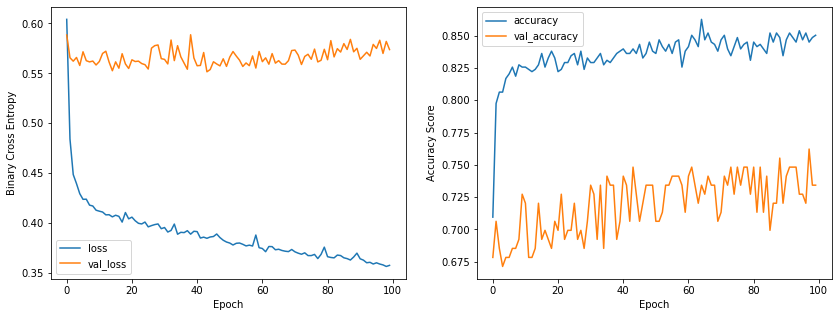

In [71]:
# plot the results of the 'fit' method

fig = plt.figure(figsize=[14, 5])
plt.subplot(1, 2, 1)
plt.plot(classy_history.history['loss'], label='loss')
plt.plot(classy_history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross Entropy')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.plot(classy_history.history['accuracy'], label='accuracy')
plt.plot(classy_history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Score')
plt.legend(loc='best')

We clearly see how the Loss function decreases during training and the Accuracy gets always better.
The fluctuations of the Validation Data does not show improvement of the model in itself, but the Accuracy on Validation data tend to increase over the epochs, which is what we want to see! 

<a id='conclusion'></a>
## Conclusion and Limitations

The Deep Learning Approach to gain Insights on the collected Data of the Passengers onboard the 'Titanic Vessel', enables us to build a Model that performs quite good at predicting wether a Passenger did survive the Tragedy or not, based on its Characteristics (Age, Travelling Class, Gender, etc...). In other words this Model could construct a complex function relating the Response Variable to all the Feature variables.
Limitation: the performance of our Model depends on the quantity of data samples available. This Dataset contains less than 1000 samples which is not much to work with. The Results are actually quite satisfying, considering this limitation. The reason is, as we could show with an Exploratory Data Analysis, that the Response is strongly correlated with some features in the Dataset ('Gender' and 'Class of Travelling' for example). A Neural Network let this correlation appear!
